## Рекомендательные системы - 2

В этом задании будем практиковаться в реализации рекомендательных систем.

Воспользуемся небольшим датасетом с Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [ ]:
%pylab inline

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Загрузка данных

Загрузим Deskdrop dataset, включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

**Но сначала разберемся с удобным для дальнейших участий и просто скачивания данных инструментом, а именно api kaggle**

0. Скачиваем kaggle

In [ ]:
! pip install --user kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Переходим сюда в ваш аккаунт kaggle и там же ищем вкладку account
2. Ищем вот такое место внизу этой вкладки: 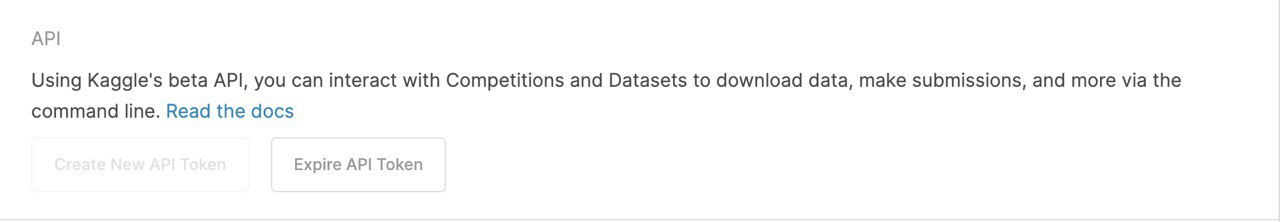 
И тут нажимаем create new api token

3. У вас скачивается файл с названием kaggle.json (обратите внимание чтобы было именно такое название, без (1) и т.д.)

4. Запускаем ниже код и выбираем вставить ваш скачанный json

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


5. Проверяем, что все работает, например, можем посмотреть какие соревнования на kaggle есть

In [ ]:
! kaggle competitions list

ref                                                                                 deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-signs                                       2023-05-01 23:59:00  Research          $100,000        210           False  
https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting       2023-03-14 23:59:00  Featured           $60,000       3230           False  
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction   2023-05-18 23:59:00  Featured           $60,000        294           False  
https://www.kaggle.com/competitions/learning-equality-curriculum-recommendations    2023-03-14 23:59:00  Featured           $55,000        961           False  
https://www.kaggle.com/competition

Ура! Теперь мы научились этим пользоваться. Также через этот инстумент можно кидать submit файлы на скор, скачивать данные без посредников. Сейчас попробуем так сделать и скачаем данные для нашей домашней работы без хитрых выкачиваний на диски или (не дай бог) на локальную машину https://www.kaggle.com/docs/api

In [ ]:
! kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop

 61% 5.00M/8.20M [00:00<00:00, 38.6MB/s]
100% 8.20M/8.20M [00:00<00:00, 53.8MB/s]


In [ ]:
! unzip articles-sharing-reading-from-cit-deskdrop.zip

Archive:  articles-sharing-reading-from-cit-deskdrop.zip
  inflating: shared_articles.csv     
  inflating: users_interactions.csv  


**Ура, мы можем работать!**

In [ ]:
!pip3 -q install cython
!pip3 -q install git+https://github.com/coreylynch/pyFM
!pip3 -q install catboost

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00


Мы загрузили Deskdrop dataset, включающийся в себе логи за 1 год платформы, где пользователи читают статьи.

Данные включают в себя 2 файла:  
- **shared_articles.csv**
- **users_interactions.csv**

Как можно догадаться, в одном описания самих статей (нам понадобятся в контентных моделях), а в другом логи пользователей.

#### shared_articles.csv

Так как в файле перечислены даже удалённые статьи, то мы их сразу удалим (на самом деле они могли бы быть нам полезны для подсчёта различных величин, хоть мы и не можем их рекомендовать).

In [ ]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


#### users_interactions.csv

В колонке eventType описаны действия, которые могли совершать пользователи над статьёй:  
- VIEW
- LIKE
- COMMENT CREATED
- FOLLOW
- BOOKMARK

In [ ]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [ ]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

### Предобработка данных

В логах встречаются различные действия пользователей. Однако мы хотим работать лишь с одной величиной, характеризующей всё взаимодействие пользователя со статьёй. Предлагается задать действиям следующие веса:

In [ ]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

Посчитаем числовую величину "оценки" пользователем статьи с указанными выше весами.

In [ ]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])
interactions_df['eventStrength']

0        1.0
1        1.0
2        1.0
3        3.0
4        1.0
        ... 
72307    2.0
72308    1.0
72309    1.0
72310    1.0
72311    1.0
Name: eventStrength, Length: 72312, dtype: float64

Ремендательные системы подвержены проблеме холодного старта. Будем работать только с теми пользователями, которые взаимодействовали хотя бы с 5-ю материалами.

Оставим только таких пользователей.

In [ ]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


<AxesSubplot:>

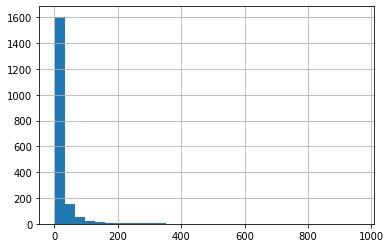

In [ ]:
users_interactions_count_df.hist(bins=30)

Оставим только те взаимодействия, которые касаются только отфильтрованных пользователей.

In [ ]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [ ]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


В данной постановке каждый пользователей мог взаимодействовать с каждой статьёй более 1 раза (как минимум совершая различные действия). Предлагается "схлопнуть" все действия в одно взаимодействие с весом, равным сумме весов. 

Однако полученное число будет в том числе тем больше, чем больше действий произвёл человек. Чтобы уменьшить разброс предлагается взять логарифм от полученного числа (можно придумывать другие веса действиям и по-другому обрабатывать значения).

Также сохраним последнее значение времени взаимодействия для разделениея выборки на обучение и контроль.

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(20)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
5,-1007001694607905623,8729086959762650511,1.000000,1487240086
6,-1032019229384696495,-1006791494035379303,1.000000,1469129122
7,-1032019229384696495,-1039912738963181810,1.000000,1459376415
8,-1032019229384696495,-1081723567492738167,2.000000,1464054093
9,-1032019229384696495,-1111518890369033396,1.000000,1470109122


Разобьём выборку на обучение и контроль по времени.

In [ ]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Также разбить данные можно не опираясь на временной фактор:
```python
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.25,
                                   random_state=42)

```
Как повлият такое разбиение на итоговый результат?

Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [ ]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


Настало время оценить качество. Посчитаем precision@10 для каждого пользователя (доля угаданных рекомендаций). Усредним по всем пользователям. Везде далее будем считать эту же метрику.

In [ ]:
def calc_precision(column):
    ####### Здесь ваш код ##########
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

    ################################

Cоставим матрицу "оценок" пользователей. Нули будут обозначать отсутствие взаимодействия.

In [ ]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId').fillna(0)

## Часть 3. Контентные  модели

В этой части реализуем альтернативный подход к рекомендательным системам — контентные модели.

Теперь мы будем оперировать не матрицей с оценками, а классической для машинного обучения матрицей объекты-признаки. Каждый объект будет характеризовать пару user-item и содержать признаки, описывающие как пользователя, так и товар. Кроме этого признаки могут описывать и саму пару целиком.

Матрица со всеми взаимодействиями уже получена нами на этапа разбиения выборки на 2 части. 

Будем обучать классификатор на взаимодействие, а для него нужны отрицательные примеры. Добавим случайные отсутствующие взаимодействия как отрицательные.

Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [ ]:
test_personId = np.repeat(interactions.index, len(ratings.columns)) 
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

Придумаем и добавим признаков о пользователях и статьях. Сначала добавим информацию о статьях в данные о взаимодействиях.

In [ ]:
interactions_train_df = interactions_train_df.merge(articles_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articles_df, how='left', on='contentId')

In [ ]:
# first feature index
features_start = len(interactions_train_df.columns)

После обучения модели нам придётся делать предсказания на тестовой выборке для всех возможных пар статья-пользователь. Подготовим такую матрицу, чтобы параллельно посчитать признаки для неё.

In [ ]:
test_personId = np.repeat(interactions.index, len(articles_df)) 
test_contentId = list(articles_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articles_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


Добавим признаки-индикаторы возможных значений contentType.

In [ ]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'

Добавим признаки "длина названия" и "длина текста" + некоторые проверки на ключевые слова.

In [ ]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

Добавим признаки-индикаторы языка.

In [ ]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'

Обучим на полученных признаках градиентный бустинг.

In [ ]:
import catboost 

model = catboost.CatBoostClassifier()
model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

Learning rate set to 0.086682
0:	learn: 0.6577976	total: 81.1ms	remaining: 1m 21s
1:	learn: 0.6291999	total: 104ms	remaining: 51.7s
2:	learn: 0.6052115	total: 129ms	remaining: 42.9s
3:	learn: 0.5859411	total: 152ms	remaining: 37.8s
4:	learn: 0.5700216	total: 186ms	remaining: 37s
5:	learn: 0.5570208	total: 213ms	remaining: 35.3s
6:	learn: 0.5461032	total: 240ms	remaining: 34.1s
7:	learn: 0.5372396	total: 268ms	remaining: 33.3s
8:	learn: 0.5298320	total: 297ms	remaining: 32.7s
9:	learn: 0.5237309	total: 326ms	remaining: 32.3s
10:	learn: 0.5185786	total: 354ms	remaining: 31.8s
11:	learn: 0.5144165	total: 383ms	remaining: 31.6s
12:	learn: 0.5108290	total: 415ms	remaining: 31.5s
13:	learn: 0.5081298	total: 446ms	remaining: 31.4s
14:	learn: 0.5058437	total: 472ms	remaining: 31s
15:	learn: 0.5037483	total: 501ms	remaining: 30.8s
16:	learn: 0.5020381	total: 528ms	remaining: 30.5s
17:	learn: 0.5005283	total: 557ms	remaining: 30.4s
18:	learn: 0.4993467	total: 588ms	remaining: 30.4s
19:	learn: 0.

Сделаем предсказания на тестовой выборке, сформируем из них рекомендации. 

In [ ]:
top_k = 10

predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])
    
interactions['prediction_content'] = tmp_predictions

<ipython-input-33-ebb56137ef64>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

Оценим их качество.

In [ ]:
calc_precision('prediction_content')

0.008239886917346681

## Часть 4. Факторизационная машина

Вспомним, что факторизационная машина учитывает попарные взаимодействия признаков, что приводит сразу и к использованию контента (сами признаки), и к обучению скрытых представлений (индикаторы пользователей и статей).

Попробуем факторизационные машины из библиотеки pyFM (так как можно работать прямо из питона). https://github.com/coreylynch/pyFM

In [ ]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

Перейдём к обобщению матричных разложений — факторизационным машинам, которые могут работать с контентной информацией. Вспомним, какие данные у нас изначально были:

В факторизационную машину можно загрузить "айдишники" пользователей и статей (то есть сделать аналог коллаборативной фильтрации) и одновременно различные признаки.

Удобно обрабатывать категориальные переменные (id и другие) можно с помощью DictVectorizer. Например, процесс может выглядеть вот так:
```python
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
y = np.repeat(1.0, X.shape[0])
fm = pylibfm.FM()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))
```

Сгенерируем таблицу с признаками в таком виде, где будут id пользователя, статьи и автора статьи и несколько признаков, которые вы сможете придумать.

In [ ]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)

    try:
        article = articles_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'

    train_data.append(features)

<ipython-input-38-44d30c7c4f98>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions_train_df))):


  0%|          | 0/146645 [00:00<?, ?it/s]

Повторим эту процедуру для тестовой выборки. Заметим, что модель оценивает каждую пару потенциального взаимодействия, а значит, надо подготовить выборку из всех возможных пар из пользователей и статей.

In [ ]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):

        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articles_df.loc[features['contentId']]
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'

        test_data.append(deepcopy(features))

<ipython-input-39-00c1bc62ab8b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions))):


  0%|          | 0/1112 [00:00<?, ?it/s]

Векторизуем, получим разреженные матрицы.

Мы будем обучать регрессор на силу взаимодействия, а для него нужны отрицательные примеры. Добавим некоторое количество случайных примеров как негативные (матрица взаимодействий разреженная, поэтому шансы взять как негативное взаимодействие некоторое положительное мало).

In [ ]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [ ]:
train_features

<246645x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 1233225 stored elements in Compressed Sparse Row format>

In [ ]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

Укажем размером скрытого представления 10, сделаем 10 итераций.

In [ ]:
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')

fm.fit(train_features, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.11744
-- Epoch 2
Training MSE: 0.11041
-- Epoch 3
Training MSE: 0.10886
-- Epoch 4
Training MSE: 0.10813
-- Epoch 5
Training MSE: 0.10747
-- Epoch 6
Training MSE: 0.10698
-- Epoch 7
Training MSE: 0.10613
-- Epoch 8
Training MSE: 0.10505
-- Epoch 9
Training MSE: 0.10387
-- Epoch 10
Training MSE: 0.10236
-- Epoch 11
Training MSE: 0.10126
-- Epoch 12
Training MSE: 0.10012
-- Epoch 13
Training MSE: 0.09902
-- Epoch 14
Training MSE: 0.09805
-- Epoch 15
Training MSE: 0.09690
-- Epoch 16
Training MSE: 0.09621
-- Epoch 17
Training MSE: 0.09538
-- Epoch 18
Training MSE: 0.09481
-- Epoch 19
Training MSE: 0.09373
-- Epoch 20
Training MSE: 0.09362
-- Epoch 21
Training MSE: 0.09278
-- Epoch 22
Training MSE: 0.09277
-- Epoch 23
Training MSE: 0.09292
-- Epoch 24
Training MSE: 0.09253
-- Epoch 25
Training MSE: 0.09237
-- Epoch 26
Training MSE: 0.09253
-- Epoch 27
Training MSE: 0.09257
-- Epoch 28
Tra

Предскажем и оценим качество.

In [ ]:
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))

In [ ]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [ ]:
calc_precision('fm_prediction')

0.007023741098952612

## Бонуc: RankFM

Статьи:
* [Раз](https://d2l.ai/chapter_recommender-systems/ranking.html)
* [Два](https://towardsdatascience.com/factorization-machines-for-item-recommendation-with-implicit-feedback-data-5655a7c749db)

[GitHub c примером](https://github.com/etlundquist/rankfm/blob/master/examples/movielens.ipynb)